# Creating a Quantum Circuit Simulator from scratch

Note: This module assumes that you are familiar with basic quantum gates and the qiskit simulator.

In [105]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

In [55]:
def x():
    return np.array([[0.0,1.0],[1.0,0.0]], dtype = 'complex')

def y():
    return np.array([[0.0,-1.0j],[1.0j,0.0]], dtype = 'complex')

def z():
    return np.array([[1.0,0.0],[0.0,-1.0]], dtype = 'complex')

def h():
    return np.sqrt(1/2)*np.array([[1.0,1.0],[1.0,-1.0]], dtype = 'complex')

def s():
    return np.array([[1.0,0.0],[0.0,1.0j]], dtype = 'complex')

def t():
    return np.array([[1,0],[0,np.exp(1.0j*np.pi/4)]], dtype = 'complex')

def projections():
    projection_0 = np.array([[1,0],[0,0]], dtype = 'complex')
    projection_1 = np.array([[0,0],[0,1]], dtype = 'complex')
    return (projection_0, projection_1)

I = np.eye(2)

In [98]:
def get_ground_state(num_qubits):
      # return vector of size 2**num_qubits with all zeroes except first element which is 1
    q = np.zeros(2**num_qubits)
    q[0] = 1
    return q

def get_operator(total_qubits, gate_string, target_qubits, params):
  # return unitary operator of size 2**n x 2**n for given gate and target qubits
    if (len(target_qubits) == 1):
        if (len(params) == 0):
            gate = I
            if (gate_string == 'x'): gate = x()
            elif (gate_string == 'y'): gate = y()
            elif (gate_string == 'z'): gate = z()
            elif (gate_string == 'h'): gate = h()
            elif (gate_string == 's'): gate = s()
            elif (gate_string == 't'): gate = t()
            
            operator_used = np.zeros(total_qubits)
            operator_used[target_qubits[0]] = 1
            final_op = I
            if (operator_used[0] == 1): 
                final_op = gate

            for i in range(1, total_qubits):
                if (operator_used[i] == 0): 
                    final_op = np.kron(final_op, I)
                else : 
                    final_op = np.kron(final_op, gate)
            return final_op
        else :
            
    
    else :
        gate = I
        if (gate_string == 'cx'): gate = x()
        elif (gate_string == 'cz'): gate = z()
        elif (gate_string == 'cy'): gate = y()
        control_bit = target_qubits[0]
        target_bit = target_qubits[1]
        if control_bit == target_bit:
            print("Error: The Control bit and The Target bit are the same, please enter the different values")
            return
        operator_used = np.zeros(total_qubits)
        operator_used[control_bit] = 1
        operator_used[target_bit] = 2
        left_tensor = I
        right_tensor = I
        
        if operator_used[0] == 1:
            left_tensor = projections()[0]
            right_tensor = projections()[1]
        elif operator_used[0] == 2:
            right_tensor = gate

        for i in range(1, total_qubits):
            if (operator_used[i] == 0): 
                left_tensor = np.kron(left_tensor, I)
                right_tensor = np.kron(right_tensor, I)
            elif (operator_used[i] == 1): 
                left_tensor = np.kron(left_tensor, projections()[0])
                right_tensor = np.kron(right_tensor, projections()[1])
            else :
                left_tensor = np.kron(left_tensor, I)
                right_tensor = np.kron(right_tensor, gate)
        
        
        return left_tensor + right_tensor
        

    

def run_program(initial_state, program):
  # read program, and for each gate:
  #   - calculate matrix operator
  #   - multiply state with operator
  # return final state
    qubits = int(math.log2(len(initial_state)))
    for i in range(0, len(program)):
        initial_state = np.dot(initial_state, get_operator(qubits, program[i]["gate"], program[i]["target"]))
    return initial_state

def measure_all(state_vector):
  # choose element from state_vector using weighted random and return it's index
    qubits = int(math.log2(len(state_vector)))
    index = ["" for x in range(len(state_vector))]
    probabilities = [abs(i)**2 for i in state_vector]
    for i in range(0, len(index)):
        index[i] = str(format(i, '00' + str(qubits) + 'b'))
    return random.choices(index, probabilities)[0]

def get_counts(state_vector, num_shots):
  # simply execute measure_all in a loop num_shots times and
  # return object with statistics in following form:
  #   {
  #      element_index: number_of_ocurrences,
  #      element_index: number_of_ocurrences,
  #      element_index: number_of_ocurrences,
  #      ...
  #   }
  # (only for elements which occoured - returned from measure_all)
    
    bin_index = ["" for x in range(len(state_vector))]
    qubits = int(math.log2(len(state_vector)))
    for i in range(0, len(bin_index)):
        bin_index[i] = str(format(i, '00' + str(qubits) + 'b'))
    
    values = {}
    
    for i in range(0, len(bin_index)):
        values[bin_index[i]]=0
    
    for i in range(0, num_shots):
        values[measure_all(state_vector)] +=1

    for i in range(0, len(bin_index)):
        if(values[bin_index[i]]==0):
            del(values[bin_index[i]])
    
    return values



In [101]:
# Define program:

my_circuit = [
{ "gate": "h", "target": [0] }, 
{ "gate": "cx", "target": [0, 1] }
]


# Create "quantum computer" with 2 qubits (this is actually just a vector :) )

my_qpu = get_ground_state(2)


# Run circuit

final_state = run_program(my_qpu, my_circuit)


# Read results

counts = get_counts(final_state, 1000)

print(counts)

# Should print something like:
# {
#   "00": 502,
#   "11": 498
# }

# Voila!


{'00': 476, '11': 524}


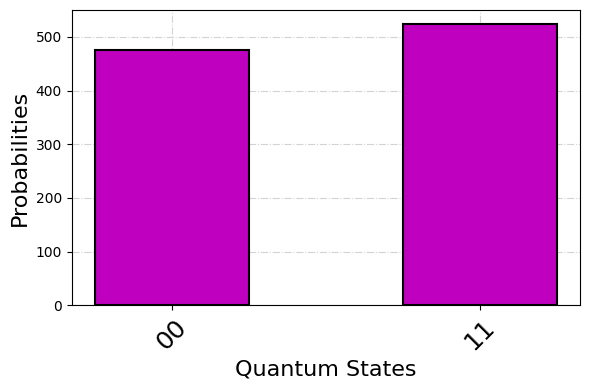

In [106]:
fig, ax = plt.subplots(1,1,dpi=100)
plt.bar(*zip(*counts.items()),color='m',width=0.5,edgecolor='k',linewidth=1.5)
x_ticks_labels = counts.keys()
ax.set_xticklabels(x_ticks_labels, rotation=45, fontsize=18)
ax.set_xlabel("Quantum States",fontsize=16)
ax.set_ylabel("Probabilities",fontsize=16)
ax.set_axisbelow(True)
ax.grid(linestyle='-.',color='lightgray',zorder=0)
fig.tight_layout()